<a href="https://colab.research.google.com/github/ibonetc/AI_Deep-Learning/blob/main/Ejemplo_Pasos_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Token de HugginFace

## Cargar el modelo

In [ ]:
# Cargamos el tokenizador y el modelo BERT en español
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model = BertModel.from_pretrained("google-bert/bert-base-multilingual-cased", output_attentions=True,output_hidden_states=True)


## Tokenización

In [ ]:
text = "El gato es un animal"
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
print(inputs)

{'input_ids': tensor([[  101, 10224, 11887, 10340, 10196, 10119, 18882,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
print(inputs.input_ids)

tensor([[  101, 10224, 11887, 10340, 10196, 10119, 18882,   102]])


## Pasos de tokenización

### Tokenización

In [ ]:
input_tokens=tokenizer.tokenize(text)
input_tokens

['El', 'ga', '##to', 'es', 'un', 'animal']

### Convierte los tokens en IDs

In [ ]:
input_ids=tokenizer.convert_tokens_to_ids(input_tokens)
input_ids

[10224, 11887, 10340, 10196, 10119, 18882]

### Adiciona tokens especiales

In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]
print("CLS: ", cls)
print("SEP: ", sep)

CLS:  [101]
SEP:  [102]


In [ ]:
input_ids_special_tokens = cls + input_ids + sep
print(input_ids_special_tokens)

[101, 10224, 11887, 10340, 10196, 10119, 18882, 102]


In [ ]:
print(inputs.input_ids.tolist()[0])

[101, 10224, 11887, 10340, 10196, 10119, 18882, 102]


In [ ]:
tokenizer.decode(inputs.input_ids.tolist()[0])

'[CLS] El gato es un animal [SEP]'

In [ ]:
tokenizer.decode(inputs.input_ids.tolist()[0],skip_special_tokens=True)

'El gato es un animal'

## Salida del Modelo

In [ ]:
model_outputs=model(**inputs)
model_outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0941,  0.1794,  0.0939,  ...,  0.1254,  0.1144,  0.0627],
         [ 0.1046, -0.0794,  0.6767,  ..., -0.0385, -0.3072,  0.3684],
         [ 0.0093, -0.0045,  1.1833,  ...,  0.2019, -0.0708,  0.0520],
         ...,
         [ 0.1916, -0.0931,  0.3403,  ...,  0.2356, -0.2352,  0.3362],
         [ 0.1173,  0.0169,  0.6499,  ...,  0.6078,  0.2432,  0.1238],
         [-0.0654,  0.1342,  0.5402,  ...,  0.2953,  0.1629,  0.2651]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 2.3709e-01, -3.2403e-02,  2.9313e-01, -6.6715e-02, -1.1262e-01,
          2.8319e-01,  7.2079e-02,  2.3989e-01, -2.8402e-01,  2.1204e-01,
          1.0143e-01, -1.4235e-01, -1.4684e-01, -1.2899e-01,  1.1217e-01,
         -1.7432e-01,  5.1512e-01, -6.9685e-02,  5.6019e-02, -3.7724e-01,
         -9.9999e-01, -1.3011e-01, -1.2995e-01, -9.8381e-02, -3.1816e-01,
          3.1131e-03, -7.4698e-02,  1.2449e-01,  9.2741e-02, -1.797

Salida sin usar gradiente

In [ ]:
with torch.no_grad():
    model_outputs = model(**inputs)

In [ ]:
model_outputs.hidden_states[0].shape

torch.Size([1, 8, 768])

In [ ]:
model_outputs.attentions[0].shape

torch.Size([1, 12, 8, 8])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
print(tokens)

['[CLS]', 'El', 'ga', '##to', 'es', 'un', 'animal', '[SEP]']


## Capas de atención

In [ ]:
attentions = model_outputs.attentions

In [ ]:
n_layers = len(model_outputs.attentions)
n_heads = n_heads = attentions[0].size(1)
print(n_layers, n_heads)

12 12


Matriz de atención de la capa 0 y la cabeza 1

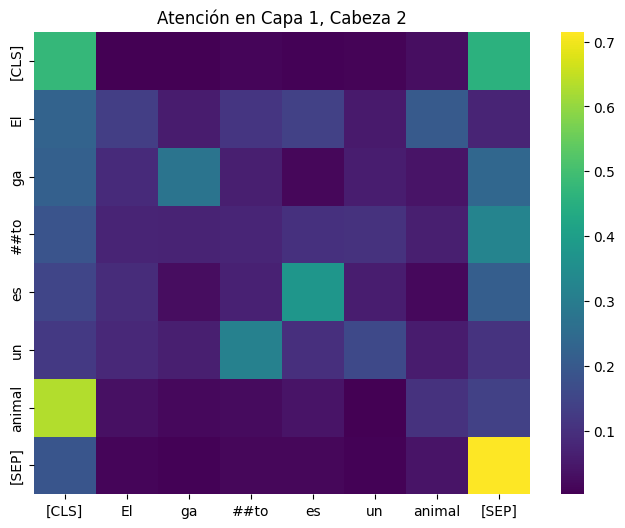

In [ ]:
layer = 0
head = 1

attention_matrix = attentions[layer][0, head].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, cmap="viridis", xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
plt.title(f"Atención en Capa {layer+1}, Cabeza {head+1}")
plt.show()

Todas las salidas de cada cabeza de atención

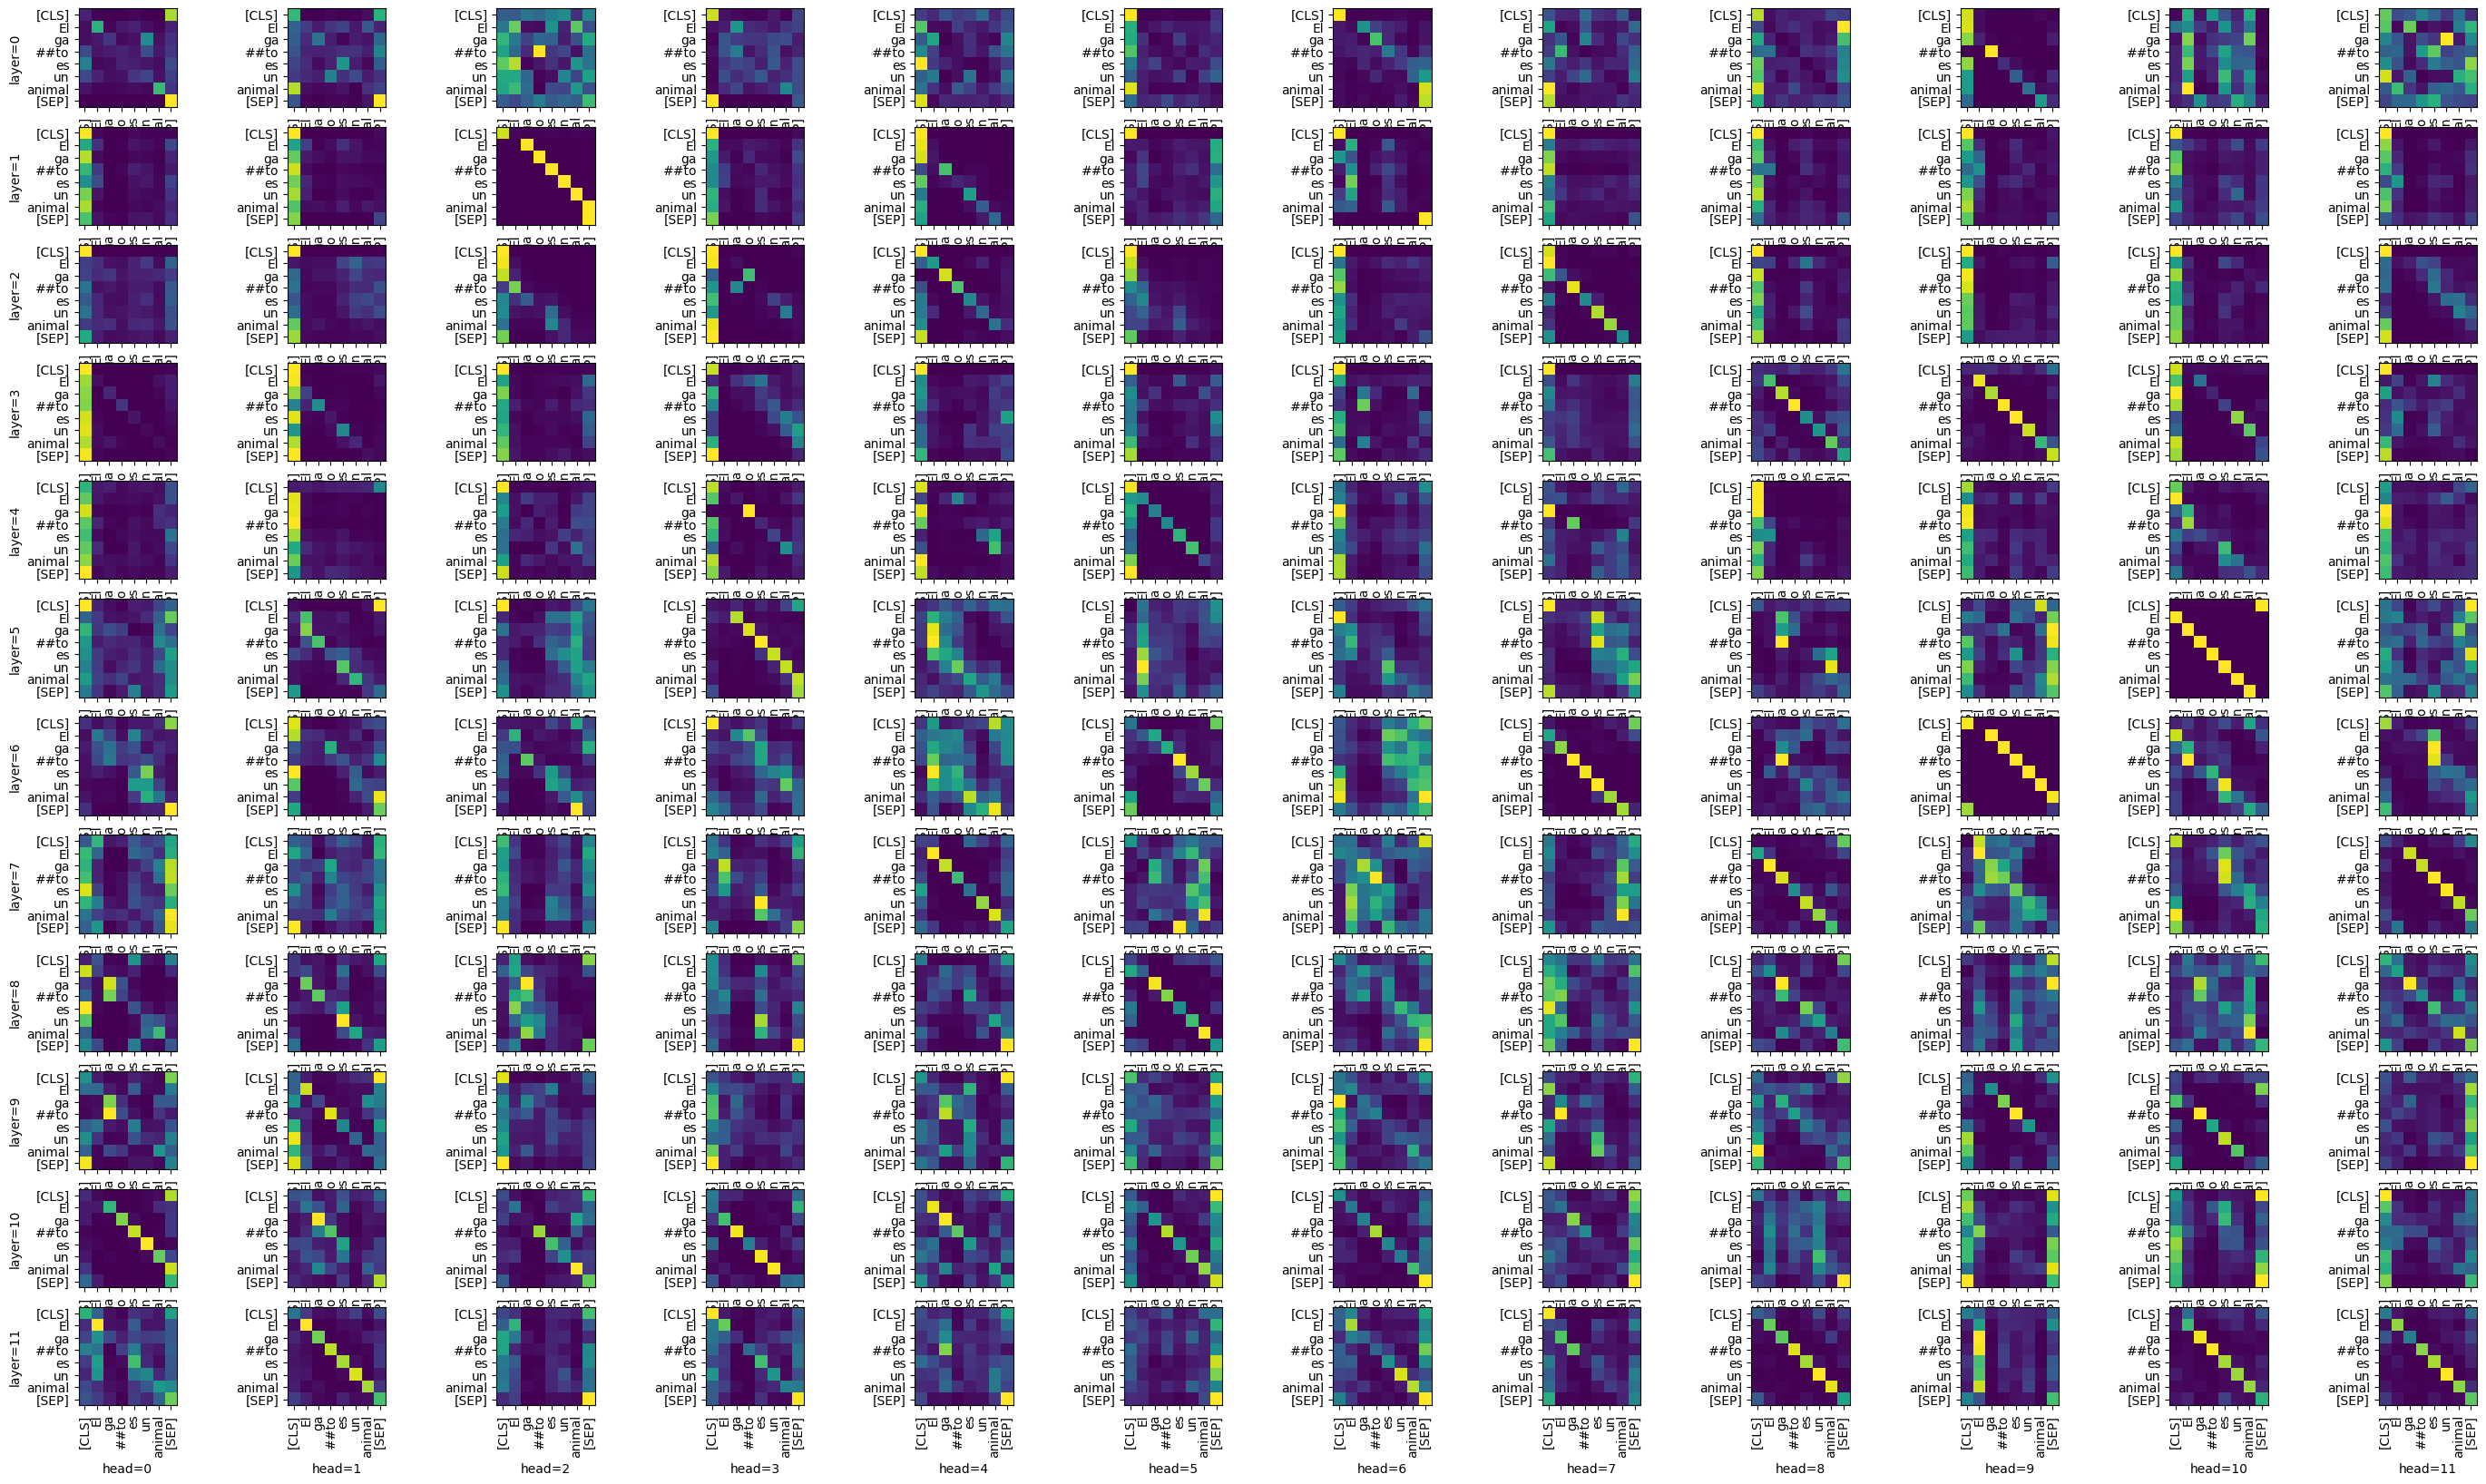

In [ ]:
fig, axes = plt.subplots(n_layers, n_heads)
fig.set_size_inches(35, 20)
for layer in range(n_layers):
    for head in range(n_heads):
        attention_matrix = attentions[layer][0, head].detach().cpu().numpy()
        axes[layer, head].imshow(attention_matrix, cmap="viridis")
        axes[layer][head].set_xticks(range(len(tokens)))
        axes[layer][head].set_xticklabels(tokens, rotation="vertical")
        axes[layer][head].set_yticks(range(len(tokens)))
        axes[layer][head].set_yticklabels(labels=tokens)

        if layer == n_layers - 1:
            axes[layer, head].set(xlabel=f"head={head}")
        if head == 0:
            axes[layer, head].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Ejemplo de salida de modelo de enmascaramiento

In [ ]:
from transformers import pipeline, AutoTokenizer,AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased", fast=True)
bert = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-cased")

2024-11-05 00:44:41.405740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
prompt = "La inteligencia artificial es una herramienta muy [MASK]."
model = pipeline("fill-mask", "google-bert/bert-base-multilingual-cased")
model(prompt)

Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.1515365093946457,
  'token': 12596,
  'token_str': 'importante',
  'sequence': 'La inteligencia artificial es una herramienta muy importante.'},
 {'score': 0.046032026410102844,
  'token': 58826,
  'token_str': 'útil',
  'sequence': 'La inteligencia artificial es una herramienta muy útil.'},
 {'score': 0.040785420686006546,
  'token': 95058,
  'token_str': 'básica',
  'sequence': 'La inteligencia artificial es una herramienta muy básica.'},
 {'score': 0.037052594125270844,
  'token': 11439,
  'token_str': 'grande',
  'sequence': 'La inteligencia artificial es una herramienta muy grande.'},
 {'score': 0.033373914659023285,
  'token': 11389,
  'token_str': 'general',
  'sequence': 'La inteligencia artificial es una herramienta muy general.'}]

In [ ]:
tokenizer.mask_token_id

103

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt")
mask_index = np.where(inputs['input_ids'] == tokenizer.mask_token_id)
outputs = bert(**inputs)
top=10
top_predictions = torch.softmax(outputs.logits[mask_index], dim=1).topk(top)
top_predictions

torch.return_types.topk(
values=tensor([[0.1515, 0.0460, 0.0408, 0.0371, 0.0334, 0.0256, 0.0239, 0.0148, 0.0128,
         0.0115]], grad_fn=<TopkBackward0>),
indices=tensor([[12596, 58826, 95058, 11439, 11389, 16205, 31854, 89294, 14855, 27971]]))

In [ ]:
for i in range(top):
    prediction = tokenizer.decode(top_predictions.indices[0, i])
    prob = top_predictions.values[0, i]
    print(f"  {i+1}) {prediction}\t{prob:.3f}")

  1) importante	0.152
  2) útil	0.046
  3) básica	0.041
  4) grande	0.037
  5) general	0.033
  6) simple	0.026
  7) larga	0.024
  8) desarrolla	0.015
  9) alta	0.013
  10) fundamental	0.011


In [ ]:
top_predictions

torch.return_types.topk(
values=tensor([[0.1515, 0.0460, 0.0408, 0.0371, 0.0334, 0.0256, 0.0239, 0.0148, 0.0128,
         0.0115]], grad_fn=<TopkBackward0>),
indices=tensor([[12596, 58826, 95058, 11439, 11389, 16205, 31854, 89294, 14855, 27971]]))

## Salidad softmax para el vocabulario

In [ ]:
torch.softmax(outputs.logits[mask_index], dim=1).shape

torch.Size([1, 119547])

In [ ]:
all_softmax_outputs = torch.softmax(outputs.logits[mask_index], dim=1)
all_softmax_outputs

tensor([[7.3640e-11, 7.7454e-11, 9.7710e-11,  ..., 3.4076e-11, 8.9937e-11,
         3.0052e-11]], grad_fn=<SoftmaxBackward0>)

In [ ]:
all_softmax_outputs[0]

tensor([7.3640e-11, 7.7454e-11, 9.7710e-11,  ..., 3.4076e-11, 8.9937e-11,
        3.0052e-11], grad_fn=<SelectBackward0>)

In [ ]:
all_softmax_outputs = torch.softmax(outputs.logits[mask_index], dim=1)
for i, prob in enumerate(all_softmax_outputs[0]):
    prediction = tokenizer.decode([i])
    print(f"{i+1}) {prediction}\t{prob.item():.3f}")

1) [PAD]	0.000
2) [unused1]	0.000
3) [unused2]	0.000
4) [unused3]	0.000
5) [unused4]	0.000
6) [unused5]	0.000
7) [unused6]	0.000
8) [unused7]	0.000
9) [unused8]	0.000
10) [unused9]	0.000
11) [unused10]	0.000
12) [unused11]	0.000
13) [unused12]	0.000
14) [unused13]	0.000
15) [unused14]	0.000
16) [unused15]	0.000
17) [unused16]	0.000
18) [unused17]	0.000
19) [unused18]	0.000
20) [unused19]	0.000
21) [unused20]	0.000
22) [unused21]	0.000
23) [unused22]	0.000
24) [unused23]	0.000
25) [unused24]	0.000
26) [unused25]	0.000
27) [unused26]	0.000
28) [unused27]	0.000
29) [unused28]	0.000
30) [unused29]	0.000
31) [unused30]	0.000
32) [unused31]	0.000
33) [unused32]	0.000
34) [unused33]	0.000
35) [unused34]	0.000
36) [unused35]	0.000
37) [unused36]	0.000
38) [unused37]	0.000
39) [unused38]	0.000
40) [unused39]	0.000
41) [unused40]	0.000
42) [unused41]	0.000
43) [unused42]	0.000
44) [unused43]	0.000
45) [unused44]	0.000
46) [unused45]	0.000
47) [unused46]	0.000
48) [unused47]	0.000
49) [unused48]	

In [ ]:
sorted_probs, sorted_indices = torch.sort(all_softmax_outputs[0], descending=True)

In [ ]:
for i in range(len(sorted_probs)):
    prediction = tokenizer.decode([sorted_indices[i].item()])
    prob = sorted_probs[i]
    print(f"{i+1}) {prediction}\t\t{prob.item():.3f}")

1) importante		0.152
2) útil		0.046
3) básica		0.041
4) grande		0.037
5) general		0.033
6) simple		0.026
7) larga		0.024
8) desarrolla		0.015
9) alta		0.013
10) fundamental		0.011
11) relevante		0.011
12) pequeña		0.010
13) común		0.010
14) bien		0.010
15) especial		0.009
16) humana		0.009
17) interesante		0.009
18) específica		0.009
19) superior		0.009
20) amplia		0.008
21) poderosa		0.008
22) científica		0.008
23) efectiva		0.008
24) utilizada		0.008
25) buena		0.007
26) industrial		0.007
27) activa		0.007
28) artificial		0.006
29) práctica		0.006
30) popular		0.006
31) aplicada		0.006
32) técnica		0.006
33) vista		0.005
34) extensa		0.005
35) baja		0.005
36) particular		0.005
37) funcional		0.005
38) sensible		0.005
39) global		0.004
40) conocida		0.004
41) usada		0.004
42) conocimiento		0.004
43) especializada		0.004
44) ##tica		0.004
45) significativa		0.004
46) tal		0.004
47) limitada		0.004
48) precisa		0.004
49) social		0.004
50) universal		0.004
51) extrema		0.003
52) ##ística